In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
%aimport awkward_1l
from awkward_1l import get_evts, has_overlap, match_dr, get_obj_sel
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak0
import awkward1 as ak
import uproot

ak.Array.flatten = lambda x : ak.to_numpy(ak.flatten(x))

In [4]:
%aimport

Modules to reload:
awkward_1l

Modules to skip:



In [5]:
rootfile = "/home/nikolai/data/user.elmsheus.21230205.EXT0._000002.DAOD_PHYSLITE.mc.pool.root"

In [6]:
%%time
evt = get_evts(
    rootfile,
)

CPU times: user 810 ms, sys: 42.7 ms, total: 853 ms
Wall time: 854 ms


In [7]:
%%time
evt = get_obj_sel(evt)

CPU times: user 467 ms, sys: 43.3 ms, total: 510 ms
Wall time: 509 ms


In [8]:
# produced with athena + ST
def get_st_ntuple():
    f = uproot.open("/home/nikolai/code/enaf/run/ST_ntuple.root")
    tree = f["analysis"]
    keys = [k.decode() for k in tree.keys()]
    evt = ak.zip(
        {
            part+"s" : ak.zip({k.split("_")[1] : ak.from_awkward0(tree[k].array()) for k in keys if part in k})
            for part in ["jet", "electron", "muon"]
        },
        depth_limit=1
    )
    # convert to bools
    bools = ["passOR", "passJvt", "baseline", "signal", "bad"]
    for part in ak.keys(evt):
        for var in ak.keys(evt[part]):
            if var in bools:
                evt[part, var] = evt[part, var] == 1
    return evt

In [9]:
st = get_st_ntuple()

In [10]:
ak.all(st.jets.pt == evt.jets.pt)

True

In [11]:
ak.count_nonzero(evt.electrons.signal != st.electrons.signal)

1000

In [12]:
ak.count_nonzero(evt.electrons.baseline != st.electrons.baseline)

8

In [13]:
ak.count_nonzero(evt.electrons.passOR != st.electrons.passOR)

50

In [14]:
ak.count_nonzero(evt.jets.passOR != st.jets.passOR)

3714

In [15]:
ak.count_nonzero(evt.jets.passOR)

293891

In [16]:
ak.count_nonzero(st.jets.passOR)

296403

In [17]:
ak.flatten(evt.electrons.signal)

<Array [True, True, True, ... True, True] type='23081 * bool'>

In [18]:
ak.flatten(st.electrons.signal)

<Array [True, True, True, ... True, True] type='23081 * bool'>

In [19]:
[ak.count_nonzero(o) for o in [st.electrons.signal, evt.electrons.signal]]

[14457, 14623]

In [20]:
print(f"    {'Uproot/Awkward':<15} {'SUSYTools':<15}")
for obj in ["electrons", "muons", "jets"]:
    print(obj)
    flags = ["all", "baseline", "passOR", "signal"]
    if obj == "jets":
        flags += ["passJvt"]
    for flag in flags:
        print("  ", flag)
        print("    ", end="")
        for e in [evt, st]:
            if flag != "all":
                count = ak.count_nonzero(e[obj, flag])
            else:
                count = ak.sum(ak.num(e[obj]))
            print(f"{count:<15}", end=" ")
        print("")

    Uproot/Awkward  SUSYTools      
electrons
   all
    23081           23081           
   baseline
    19211           19219           
   passOR
    18905           18907           
   signal
    14623           14457           
muons
   all
    26475           26475           
   baseline
    23310           22826           
   passOR
    22536           19455           
   signal
    18226           17453           
jets
   all
    524205          524205          
   baseline
    318948          318948          
   passOR
    293891          296403          
   signal
    299005          298842          
   passJvt
    505879          505716          


In [21]:
# produced with SUSY 1L framework (based on ST)
with uproot.open("/home/nikolai/data/1l_ntuple_physlite_nomet.root") as f:
    df_ntup = f["tree_NoSys"].pandas.df()

In [22]:
df_ntup

trigWeight_metTrig  trigMatch_metTrig  trigWeight_singleLepTrig  \
entry                                                                    
0                     1.0              False                       1.0   
1                     1.0              False                       1.0   
2                     1.0               True                       1.0   
3                     1.0              False                       1.0   
4                     1.0               True                       1.0   
...                   ...                ...                       ...   
23646                 1.0               True                       1.0   
23647                 1.0              False                       1.0   
23648                 1.0              False                       1.0   
23649                 1.0              False                       1.0   
23650                 1.0              False                       1.0   

       trigMatch_singleLepTrig  nLep_base  nLep_signal   mu  actual_mu  \
entry                                                                    
0                        False          1            1  1.0        1.0   
1                        False          1            1  1.0        1.0   
2                         True          1            1  1.0        1.0   
3                        False          1            1  1.0        1.0   
4                         True          1            1  1.0        1.0   
...                        ...        ...          ...  ...        ...   
23646                    False          1            1  1.0        1.0   
23647                    False          1            1  1.0        1.0   
23648                    False          1            1  1.0        1.0   
23649                     True          1            1  1.0        1.0   
23650                     True          1            1  1.0        1.0   

       AnalysisType  lep1Charge  ...  lep1Origin  PRWHash  EventNumber  \
entry                            ...                                     
0                 1           1  ...          26        1     61904170   
1                 2           1  ...          10        1     61905971   
2                 2           1  ...          10        1     61904880   
3                 2          -1  ...          10        1     61905683   
4                 1          -1  ...          10        1     61905375   
...             ...         ...  ...         ...      ...          ...   
23646             2          -1  ...          10        1     61282936   
23647             2           1  ...          10        1     61281864   
23648             1           1  ...          10        1     61282737   
23649             2          -1  ...          10        1     61281327   
23650             1           1  ...          10        1     61281321   

             xsec       GenHt      GenMET  DatasetNumber  RunNumber  \
entry                                                                 
0      452.311096  241.850739   56.210144         410470     300000   
1      452.311096  249.331207   26.812399         410470     300000   
2      452.311096  309.697662   91.673943         410470     300000   
3      452.311096  162.561859   39.935741         410470     300000   
4      452.311096  323.975800  113.653320         410470     300000   
...           ...         ...         ...            ...        ...   
23646  452.311096  266.678131  180.656052         410470     300000   
23647  452.311096  117.300507   23.066416         410470     300000   
23648  452.311096  393.031006   26.599106         410470     300000   
23649  452.311096  355.657166   31.706877         410470     300000   
23650  452.311096  274.872711   54.299911         410470     300000   

       RandomRunNumber  FS  
entry                       
0               327862   0  
1               339535   0  
2               331129   0  
3               339849   0  
4               3388

In [23]:
def signal_jets(evt):
    return evt.jets[evt.jets.signal & evt.jets.passOR & (evt.jets.pt > 25000) & (np.abs(evt.jets.eta) < 2.8)]

In [24]:
# for comparison with SUSY 1L framework
def cutflow(evt):
    print(f"{'All:':<30} {len(evt)}")
    evt = evt[ak.num(signal_jets(evt)) >= 1] # at least one jet
    print(f"{'At least one jet with pt>25:':<30} {len(evt)}")
    electrons = evt.electrons[evt.electrons.passOR]
    muons = evt.muons[evt.muons.passOR]
    n_lep_signal = ak.num(electrons[electrons.signal]) + ak.num(muons[muons.signal])
    evt = evt[n_lep_signal == 1]
    print(f"{'Exactly one signal lepton:':<30} {len(evt)}")
    electrons = evt.electrons[evt.electrons.passOR]
    muons = evt.muons[evt.muons.passOR]
    n_lep_base = ak.num(electrons[electrons.baseline]) + ak.num(muons[muons.baseline])
    evt = evt[n_lep_base == 1]
    print(f"{'Second (baseline) lepton veto:':<30} {len(evt)}")
    return evt

In [25]:
def signal_leptons(evt):
    electrons = evt.electrons[evt.electrons.passOR]
    muons = evt.muons[evt.muons.passOR]
    return ak.where(
        ak.num(electrons[electrons.signal]) == 1,
        electrons[electrons.signal],
        muons[muons.signal]
    )

In [26]:
e1 = cutflow(evt)

All:                           50000
At least one jet with pt>25:   49800
Exactly one signal lepton:     26228
Second (baseline) lepton veto: 23115


In [27]:
def ratioplot(ax, ax2, x_uproot, x_ntuple, opts=dict(bins=100, range=(25, 1000), alpha=0.5)):
    h1 = ax.hist(
        x_uproot,
        label="Uproot/Awkward",
        **opts
    )
    h2 = ax.hist(x_ntuple, label="1l ntuple", **opts)
    hist1 = np.append(h1[0], h1[0][-1])
    hist2 = np.append(h2[0], h2[0][-1])
    ax2.step(h1[1], hist1 / hist2, where="post")
    ax2.axhline(1, linestyle="--", color="black", alpha=0.5)
    ax2.set_ylabel("Ratio")
    #bar_width = h1[1][1] - h1[1][0]
    #ax2.bar(h1[1][:-1] + 0.5 * bar_width, (hist1[:-1] - hist2[:-1]) / np.sqrt(hist1[:-1]), width=bar_width)
    #ax2.axhline(0, linestyle="--", color="black", alpha=0.5)
    #ax2.set_ylabel("$\Delta h / \sqrt{h}$")
    lim = ax.get_xlim()
    ax2.set_xlim(*lim)

<ipython-input-27-ffc79cff7422>:10: RuntimeWarning: divide by zero encountered in true_divide
  ax2.step(h1[1], hist1 / hist2, where="post")
<ipython-input-27-ffc79cff7422>:10: RuntimeWarning: invalid value encountered in true_divide
  ax2.step(h1[1], hist1 / hist2, where="post")


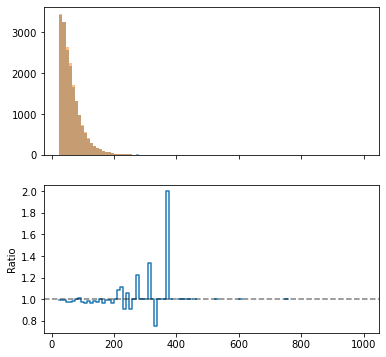

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 6), sharex=True)
ax, ax2 = axs
ratioplot(
    ax,
    ax2,
    ak.to_numpy(signal_leptons(e1).pt) / 1000,
    df_ntup.lep1Pt,
)

<ipython-input-27-ffc79cff7422>:10: RuntimeWarning: invalid value encountered in true_divide
  ax2.step(h1[1], hist1 / hist2, where="post")


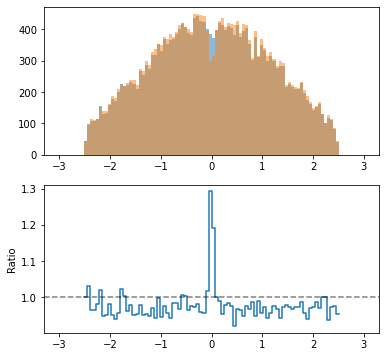

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))
ax, ax2 = axs
ratioplot(
    ax,
    ax2,
    ak.to_numpy(signal_leptons(e1).eta),
    df_ntup.lep1Eta,
    opts=dict(bins=100, range=(-3, 3), alpha=0.5)
)

<ipython-input-27-ffc79cff7422>:10: RuntimeWarning: divide by zero encountered in true_divide
  ax2.step(h1[1], hist1 / hist2, where="post")
<ipython-input-27-ffc79cff7422>:10: RuntimeWarning: invalid value encountered in true_divide
  ax2.step(h1[1], hist1 / hist2, where="post")
<ipython-input-27-ffc79cff7422>:10: RuntimeWarning: invalid value encountered in true_divide
  ax2.step(h1[1], hist1 / hist2, where="post")


<a list of 0 Line2D objects>


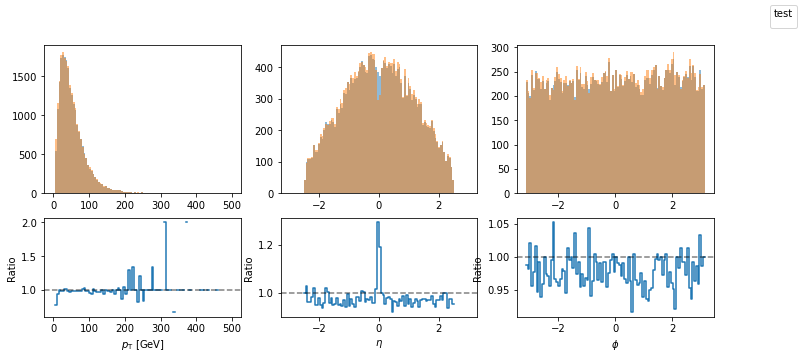

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), gridspec_kw=dict(height_ratios=[3, 2]))
ratioplot(
    ax[0][0],
    ax[1][0],
    ak.to_numpy(signal_leptons(e1).pt) / 1000,
    df_ntup.lep1Pt,
    opts=dict(bins=100, range=(0, 500), alpha=0.5),
)
ax[1][0].set_xlabel("$p_\mathrm{T}$ [GeV]")
ratioplot(
    ax[0][1],
    ax[1][1],
    ak.to_numpy(signal_leptons(e1).eta),
    df_ntup.lep1Eta,
    opts=dict(bins=100, range=(-3, 3), alpha=0.5),
)
ax[1][1].set_xlabel("$\eta$")
ratioplot(
    ax[0][2],
    ax[1][2],
    ak.to_numpy(signal_leptons(e1).phi),
    df_ntup.lep1Phi,
    opts=dict(bins=100, range=(-np.pi, np.pi), alpha=0.5),
)
print(ax[0][2].get_lines())
ax[1][2].set_xlabel("$\phi$")
fig.legend(handles=list(ax[0][2].get_lines()), title="test")
fig.savefig("lep1.pdf")

In [31]:
def leading_jet(jets):
    return jets[ak.singletons(ak.argmax(jets.pt, axis=1))]

<ipython-input-27-ffc79cff7422>:10: RuntimeWarning: invalid value encountered in true_divide
  ax2.step(h1[1], hist1 / hist2, where="post")
<ipython-input-27-ffc79cff7422>:10: RuntimeWarning: invalid value encountered in true_divide
  ax2.step(h1[1], hist1 / hist2, where="post")


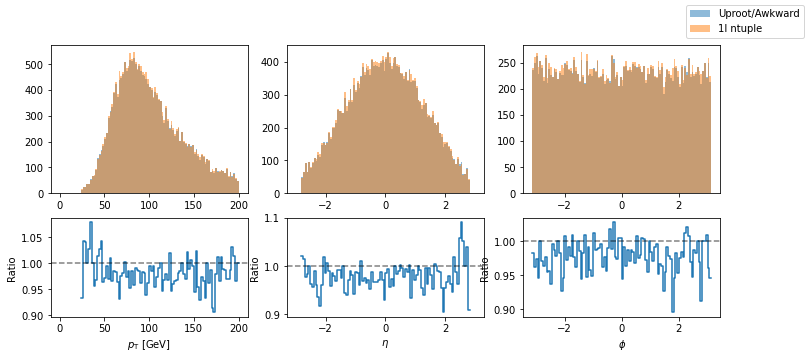

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), gridspec_kw=dict(height_ratios=[3, 2]))
ratioplot(
    ax[0][0],
    ax[1][0],
    ak.to_numpy(leading_jet(signal_jets(e1)).pt) / 1000,
    df_ntup.jet1Pt,
    opts=dict(bins=100, range=(0, 200), alpha=0.5),
)
ax[1][0].set_xlabel("$p_\mathrm{T}$ [GeV]")
ratioplot(
    ax[0][1],
    ax[1][1],
    ak.to_numpy(leading_jet(signal_jets(e1)).eta),
    df_ntup.jet1Eta,
    opts=dict(bins=100, range=(-3, 3.), alpha=0.5),
)
ax[1][1].set_xlabel("$\eta$")
ratioplot(
    ax[0][2],
    ax[1][2],
    ak.to_numpy(leading_jet(signal_jets(e1)).phi),
    df_ntup.jet1Phi,
    opts=dict(bins=100, range=(-np.pi, np.pi), alpha=0.5),
)
ax[1][2].set_xlabel("$\phi$")
fig.legend(*ax[0][2].get_legend_handles_labels())
fig.savefig("jet1.pdf")

<ipython-input-27-ffc79cff7422>:10: RuntimeWarning: invalid value encountered in true_divide
  ax2.step(h1[1], hist1 / hist2, where="post")


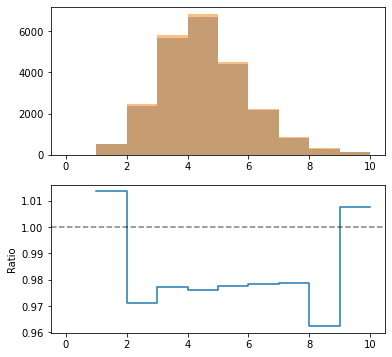

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))
ax, ax2 = axs
ratioplot(
    ax, ax2,
    ak.num(signal_jets(e1)),
    df_ntup.nJet25.to_numpy(),
    opts=dict(bins=10, range=(0, 10), alpha=0.5)
)

In [34]:
evt.layout.form

{
    "class": "RecordArray",
    "contents": {
        "electrons": {
            "class": "ListOffsetArray64",
            "offsets": "i64",
            "content": {
                "class": "RecordArray",
                "contents": {
                    "pt": "float32",
                    "eta": "float32",
                    "phi": "float32",
                    "DFCommonElectronsLHLooseBL": "int8",
                    "DFCommonElectronsLHTight": "int8",
                    "topoetcone20": "float32",
                    "ptvarcone20_TightTTVA_pt1000": "float32",
                    "baseline": "bool",
                    "signal": "bool",
                    "passOR": "bool"
                }
            }
        },
        "jets": {
            "class": "ListOffsetArray64",
            "offsets": "i64",
            "content": {
                "class": "RecordArray",
                "contents": {
                    "pt": "float32",
                    "eta": "float32",
       